In [2]:
"""
Code for the publication Exploiting Flexibility in Multi-Energy Systems
through Distributionally Robust Chance-Constrained
Optimization by Marwan Mostafa 

Main File
"""
###############################################################################
## IMPORT PACKAGES & SCRIPTS ## 
###############################################################################
#### SCRIPTS ####
import data as dt
import griddata as gd 
import results as rs
import plot as pl
import opf as opf

net, df_pv, df, pv_generators, const_load, const_pv  = gd.setup_grid()

print(df_pv.columns)

Index(['time', 'pvgen', 'pvgen_bus_12', 'pvgen_bus_16', 'pvgen_bus_17',
       'pvgen_bus_18', 'pvgen_bus_19'],
      dtype='object')


In [9]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)
file_path = 'heatpumpPrognosis.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(df.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(df.columns)

# Print the length of the 'dayOfWeek' column
print("\nLength of the 'dayOfWeek' column:")
print(df['meanP'].count())  # .count() counts non-null entries in the column

# Print the last two values in the 'dayOfWeek' column
print("\nLast two values in the 'dayOfWeek' column:")
print(df['meanP'].tail(2))

First few rows of the data:
   Unnamed: 0  season  dayOfWeek  hour  minute            meanP  \
0           0  winter          0     0       0   25194,91015625   
1           1  winter          0     0      15   25218,71484375   
2           2  winter          0     0      30    24989,3203125   
3           3  winter          0     0      45    24909,6796875   
4           4  winter          0     1       0  24786,275390625   

               stdP             meanQ               stdQ  
0   5921,6005859375     12887,4921875     2639,576171875  
1  5998,33544921875  12727,0361328125    2601,7177734375  
2  6046,88916015625  12579,3388671875   2668,59521484375  
3  6160,70947265625  12556,0927734375  2625,509033203125  
4  6204,25634765625     12498,5234375    2637,5888671875  

Column names (Header):
Index(['Unnamed: 0', 'season', 'dayOfWeek', 'hour', 'minute', 'meanP', 'stdP',
       'meanQ', 'stdQ'],
      dtype='object')

Length of the 'dayOfWeek' column:
2016

Last two values in the '

In [5]:
import pandas as pd

# Load the CSV file (replace 'your_file.csv' with the actual file path)
file_path = 'realData.csv'
df = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(df.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(df.columns)

# Print the length of the dataframe (number of rows)
print("\nNumber of rows in the data:")
print(len(df))

# Print the last two rows of the dataframe
print("\nLast two rows of the data:")
print(df.tail(2))


First few rows of the data:
            Unnamed: 0         P_HOUSEHOLD         Q_HOUSEHOLD  \
0  2020-01-01 00:00:00  11195,931994840836  -1642,766109249328   
1  2020-01-01 00:15:00  11195,931994840836  -1642,766109249328   
2  2020-01-01 00:30:00  11195,931994840836  -1642,766109249328   
3  2020-01-01 00:45:00  11195,931994840836  -1642,766109249328   
4  2020-01-01 01:00:00   9996,504786131114  -467,3660027431103   

          P_HEATPUMP          Q_HEATPUMP P_PV Q_PV  
0  35852,36386483509  14027,695428514486  0,0  0,0  
1  35852,36386483509  14027,695428514486  0,0  0,0  
2  35852,36386483509  14027,695428514486  0,0  0,0  
3  35852,36386483509  14027,695428514486  0,0  0,0  
4  45086,04602229863   18400,79378886753  0,0  0,0  

Column names (Header):
Index(['Unnamed: 0', 'P_HOUSEHOLD', 'Q_HOUSEHOLD', 'P_HEATPUMP', 'Q_HEATPUMP',
       'P_PV', 'Q_PV'],
      dtype='object')

Number of rows in the data:
11712

Last two rows of the data:
                Unnamed: 0        P_HOUSEHOLD

In [11]:
import pandas as pd

# Load the CSV file (replace 'realData.csv' with the actual file path)
file_path = 'realData.csv'
df = pd.read_csv(file_path, sep=';', decimal=',')

# Convert the 'Unnamed: 0' column to a datetime format and set it as the index
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Unnamed: 0', inplace=True)

# Select the first 7 days (with 15-minute intervals, there are 96 intervals per day)
first_week = df.loc[df.index < df.index[0] + pd.Timedelta(days=7)]

# Select only 'P_HOUSEHOLD' and 'P_HEATPUMP' columns for the first week
realData_winter = first_week[['P_HOUSEHOLD', 'P_HEATPUMP']]

# Display the first few rows of the dataframe
print("First few rows of the data:")
print(realData_winter.head())

# Display the header (column names) of the dataframe
print("\nColumn names (Header):")
print(realData_winter.columns)

# Print the length of the dataframe (number of rows)
print("\nNumber of rows in the data:")
print(len(realData_winter))

# Print the last two rows of the dataframe
print("\nLast two rows of the data:")
print(realData_winter.tail(2))

# Export realData_winter to a CSV file
output_file_path = 'realData_winter.csv'
realData_winter.to_csv(output_file_path, sep=';', decimal=',', index=True)

print(f"realData_winter has been successfully saved to {output_file_path}")

First few rows of the data:
                      P_HOUSEHOLD    P_HEATPUMP
Unnamed: 0                                     
2020-01-01 00:00:00  11195.931995  35852.363865
2020-01-01 00:15:00  11195.931995  35852.363865
2020-01-01 00:30:00  11195.931995  35852.363865
2020-01-01 00:45:00  11195.931995  35852.363865
2020-01-01 01:00:00   9996.504786  45086.046022

Column names (Header):
Index(['P_HOUSEHOLD', 'P_HEATPUMP'], dtype='object')

Number of rows in the data:
672

Last two rows of the data:
                     P_HOUSEHOLD    P_HEATPUMP
Unnamed: 0                                    
2020-01-07 23:30:00  6120.643999  19555.089684
2020-01-07 23:45:00  5694.966446  29961.606471
realData_winter has been successfully saved to realData_winter.csv


C:\Users\ckw5258\AppData\Local\Temp\ipykernel_20632\1295299873.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_data['meanP'] = winter_data['meanP'].str.replace(',', '.').astype(float)


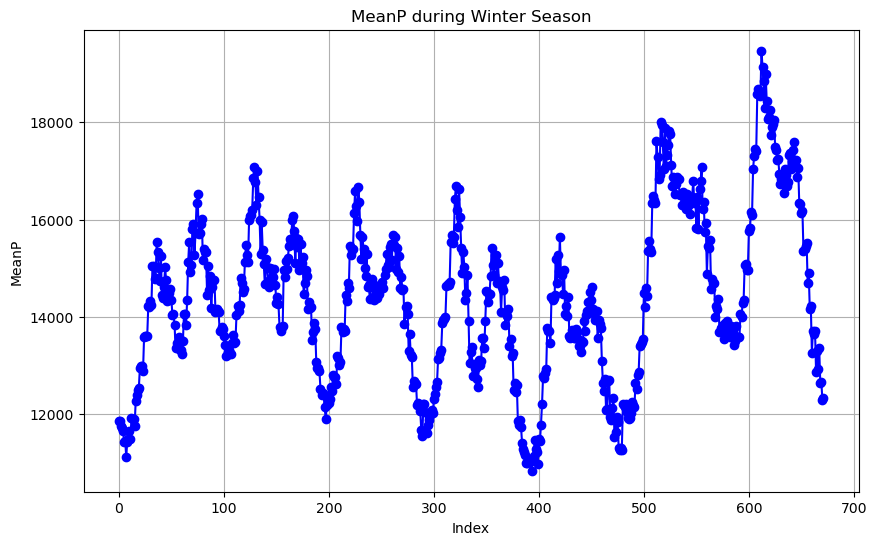

In [2]:
import matplotlib.pyplot as plt
# Filter the data for rows where season is 'winter'
winter_data = df[df['season'] == 'winter']

# Convert the 'meanP' column to numeric, replacing commas with dots
winter_data['meanP'] = winter_data['meanP'].str.replace(',', '.').astype(float)

# Plot the 'meanP' column
plt.figure(figsize=(10, 6))
plt.plot(winter_data['meanP']*(32/68), marker='o', linestyle='-', color='b')
plt.title('MeanP during Winter Season')
plt.xlabel('Index')
plt.ylabel('MeanP')
plt.grid(True)
plt.show()